In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Grad-CAM 및 시각화를 위한 추가 라이브러리 import
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
import cv2 # Grad-CAM에서 이미지 리사이징에 사용 (설치 필요: pip install opencv-python)

print(tf.__version__)
print(np.__version__)
print("PIL 라이브러리 import 완료!")

2.6.0
1.22.2
PIL 라이브러리 import 완료!


In [3]:
def set_deterministic_mode(seed_value):
    # 1. 파이썬, NumPy, TensorFlow의 난수 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    
    # 2. GPU 결정성 모드 강제 설정 (학습 속도 저하 가능성 있음)
    # NOTE: 모든 GPU 연산이 결정적(Deterministic) 순서로 실행되도록 강제
    os.environ['TF_DETERMINISTIC_OPS'] = '1' 
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# 시드 값 설정 및 함수 호출
SEED = 42
set_deterministic_mode(SEED)

In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")

	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size, Image.LANCZOS)
		new_img.save(img, "JPEG")

	print(len(images), " images resized.")

# 모든 이미지 리사이즈 (가정: 훈련 데이터 경로)
image_dir_path_train_base = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
resize_images(image_dir_path_train_base + "/scissor")
resize_images(image_dir_path_train_base + "/rock")
resize_images(image_dir_path_train_base + "/paper")
print("훈련 이미지 resize 완료!")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
훈련 이미지 resize 완료!


In [5]:
def load_data(img_path, number_of_data):  # number_of_data를 명시적으로 받도록 수정
	# 가위 : 0, 바위 : 1, 보 : 2
	img_size=28
	color=3
	imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
	labels=np.zeros(number_of_data,dtype=np.int32)

	idx=0
	# --- 가위(0) 이미지 로드 ---
	for file in glob.iglob(img_path+'/scissor/*.jpg'):
		if idx == number_of_data: break
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=0
		idx=idx+1

	# --- 바위(1) 이미지 로드 ---
	for file in glob.iglob(img_path+'/rock/*.jpg'):
		if idx == number_of_data: break
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=1
		idx=idx+1

	# --- 보(2) 이미지 로드 ---
	for file in glob.iglob(img_path+'/paper/*.jpg'):
		if idx == number_of_data: break
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=2
		idx=idx+1

	print("로드된 이미지 개수는", idx,"입니다.")
	return imgs[:idx], labels[:idx]

In [6]:
TRAIN_DATA_COUNT = 300
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train_raw, y_train)=load_data(image_dir_path, number_of_data=TRAIN_DATA_COUNT)
x_train = x_train_raw/255.0

print("\n--- 훈련 데이터 정보 ---")
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

로드된 이미지 개수는 300 입니다.

--- 훈련 데이터 정보 ---
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


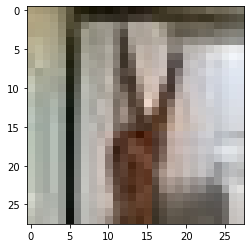

In [7]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [8]:
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D((2,2)))
# NOTE: Grad-CAM을 위해 이 레이어를 'target_layer'로 설정할 수 있습니다.
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu', name='last_conv_layer')) 
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(3, activation='softmax'))

print("\n--- 모델 구조 (2차 시도) ---")
model.summary()


--- 모델 구조 (2차 시도) ---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
last_conv_layer (Conv2D)     (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (Non

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15, zoom_range=0.1, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest'
)

BATCH_SIZE = 32

print("\n--- 모델 훈련 (데이터 증강 적용) ---")
# datagen.flow() 호출 시
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=False), # ⭐ shuffle=False 추가
    epochs=n_train_epoch,
    steps_per_epoch=int(np.ceil(TRAIN_DATA_COUNT / BATCH_SIZE))
)


--- 모델 훈련 (데이터 증강 적용) ---
Epoch 1/20
10/10 [==============================] - 1s 60ms/step - loss: 1.2446 - accuracy: 0.2533
Epoch 2/20
10/10 [==============================] - 0s 49ms/step - loss: 1.1115 - accuracy: 0.1800
Epoch 3/20
10/10 [==============================] - 1s 52ms/step - loss: 1.0975 - accuracy: 0.3567
Epoch 4/20
10/10 [==============================] - 1s 51ms/step - loss: 1.1044 - accuracy: 0.3167
Epoch 5/20
10/10 [==============================] - 1s 52ms/step - loss: 1.0945 - accuracy: 0.3367
Epoch 6/20
10/10 [==============================] - 1s 52ms/step - loss: 1.0810 - accuracy: 0.4000
Epoch 7/20
10/10 [==============================] - 1s 48ms/step - loss: 1.1140 - accuracy: 0.3333
Epoch 8/20
10/10 [==============================] - 1s 52ms/step - loss: 1.0845 - accuracy: 0.3633
Epoch 9/20
10/10 [==============================] - 1s 50ms/step - loss: 1.0650 - accuracy: 0.4767
Epoch 10/20
10/10 [==============================] - 1s 52ms/step - loss: 1.0866 -

In [10]:
image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
resize_images(image_dir_path_test + "/scissor")
resize_images(image_dir_path_test + "/rock")
resize_images(image_dir_path_test + "/paper")

TEST_DATA_COUNT = 313

(x_test_raw, y_test)=load_data(image_dir_path_test, number_of_data=TEST_DATA_COUNT)
x_test = x_test_raw/255.0

print("\n--- 테스트 데이터 정보 ---")
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

print("\n--- 모델 성능 평가 ---")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {} ".format(test_accuracy))

107  images to be resized.
107  images resized.
102  images to be resized.
102  images resized.
104  images to be resized.
104  images resized.
로드된 이미지 개수는 313 입니다.

--- 테스트 데이터 정보 ---
x_test shape: (313, 28, 28, 3)
y_test shape: (313,)

--- 모델 성능 평가 ---
10/10 - 0s - loss: 0.9591 - accuracy: 0.6070
test_loss: 0.959128201007843 
test_accuracy: 0.6070287823677063 


In [11]:
## Grad-CAM 함수 구현
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM 히트맵을 생성합니다."""
    # 1. 모델의 입력 이미지와 마지막 컨볼루션 레이어 출력, 최종 예측 레이어 출력을 연결하는 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # 가장 높은 확률을 가진 클래스의 인덱스를 선택
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 2. 최종 예측 클래스 출력에 대한 마지막 컨볼루션 레이어 출력의 기울기(gradient) 계산
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 3. 각 특징 맵(Feature Map)의 평균 기울기 계산 (Global Average Pooling 역할)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. 특징 맵에 평균 기울기를 곱하여 히트맵 생성
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 5. ReLU 적용 및 정규화
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Grad-CAM 히트맵을 원본 이미지에 겹쳐서 시각화합니다."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (28, 28)) # 원본 이미지를 28x28로 리사이즈
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 히트맵을 이미지 크기에 맞게 리사이즈
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # 컬러맵 적용
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # 히트맵을 255 스케일로 변환
    jet_heatmap = np.uint8(255 * jet_heatmap)
    
    # 원본 이미지 위에 히트맵 오버레이
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Analysis")
    plt.axis('off')
    plt.show()


--- Grad-CAM 분석 예시 ---


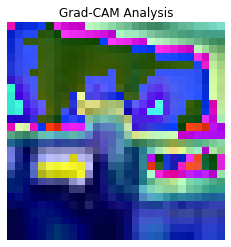

In [12]:
## Grad-CAM 실행 (일단 클래스별 1장씩만)
print("\n--- Grad-CAM 분석 예시 ---")
# 분석할 이미지 경로 설정 (예시: 테스트 데이터의 첫 번째 바위 이미지 경로 가정)
# NOTE: 실제 환경에 맞게 경로를 수정해야 합니다.
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock/0.jpg"

# 1. 이미지 로드 및 전처리 (모델 입력 형태 맞추기)
img_array = x_test[0:1] # 첫 번째 테스트 이미지 (배치 차원 추가)

# 2. Grad-CAM 히트맵 생성
# 'last_conv_layer'는 모델 정의 시 지정한 마지막 Conv2D 레이어의 이름
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')

# 3. 결과 시각화
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")


--- Grad-CAM 분석 예시 ---


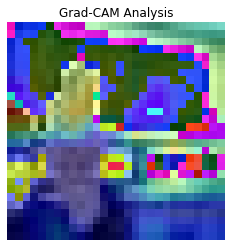

In [13]:
## Grad-CAM 실행 (일단 클래스별 1장씩만)
print("\n--- Grad-CAM 분석 예시 ---")
# 분석할 이미지 경로 설정 (예시: 테스트 데이터의 첫 번째 보자기 이미지 경로 가정)
# NOTE: 실제 환경에 맞게 경로를 수정해야 합니다.
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper/0.jpg"

# 1. 이미지 로드 및 전처리 (모델 입력 형태 맞추기)
img_array = x_test[0:1] # 첫 번째 테스트 이미지 (배치 차원 추가)

# 2. Grad-CAM 히트맵 생성
# 'last_conv_layer'는 모델 정의 시 지정한 마지막 Conv2D 레이어의 이름
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')

# 3. 결과 시각화
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")


--- Grad-CAM 분석 예시 ---


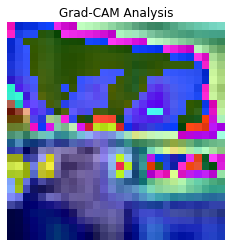

In [14]:
## Grad-CAM 실행 (일단 클래스별 1장씩만)
print("\n--- Grad-CAM 분석 예시 ---")
# 분석할 이미지 경로 설정 (예시: 테스트 데이터의 첫 번째 가위 이미지 경로 가정)
# NOTE: 실제 환경에 맞게 경로를 수정해야 합니다.
example_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor/0.jpg"

# 1. 이미지 로드 및 전처리 (모델 입력 형태 맞추기)
img_array = x_test[0:1] # 첫 번째 테스트 이미지 (배치 차원 추가)

# 2. Grad-CAM 히트맵 생성
# 'last_conv_layer'는 모델 정의 시 지정한 마지막 Conv2D 레이어의 이름
heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer')

# 3. 결과 시각화
try:
    display_gradcam(example_img_path, heatmap)
except Exception as e:
    print(f"Grad-CAM 시각화 중 오류 발생: {e}. (OpenCV 및 실제 이미지 경로 확인 필요)")

In [15]:
## 가중치(Weights) 및 편향(Bias) 추출
print("\n--- 가중치(Weights) 및 편향(Bias) 추출 ---")

# 첫 번째 컨볼루션 레이어 분석
conv1_layer = model.layers[0] 
weights_c1, biases_c1 = conv1_layer.get_weights() 
print("Conv1 레이어:")
print(f"  Weights shape (커널): {weights_c1.shape}") # (3, 3, 3, 32)
print(f"  Biases shape: {biases_c1.shape}")           # (32,)

# 첫 번째 Dense 레이어 분석 (특징 조합 능력 확인)
dense1_layer = model.layers[6] # Flatten, Dropout 제외
weights_d1, biases_d1 = dense1_layer.get_weights() 
print("Dense1 레이어:")
print(f"  Weights shape: {weights_d1.shape}") # (Flatten 출력 크기, 128)
print(f"  Biases shape: {biases_d1.shape}")           # (128,)


--- 가중치(Weights) 및 편향(Bias) 추출 ---
Conv1 레이어:
  Weights shape (커널): (3, 3, 3, 32)
  Biases shape: (32,)
Dense1 레이어:
  Weights shape: (1600, 128)
  Biases shape: (128,)


In [18]:
# Conv1 가중치 통계량 출력
print("\n--- Conv1 Weights (커널 값) 통계 ---")
print(f"  Min: {np.min(weights_c1):.6f}")
print(f"  Max: {np.max(weights_c1):.6f}")
print(f"  Mean: {np.mean(weights_c1):.6f}")
print(f"  Std Dev: {np.std(weights_c1):.6f}")

print("\n--- Dense1 Weights 통계 ---")
print(f"  Min: {np.min(weights_d1):.6f}")
print(f"  Max: {np.max(weights_d1):.6f}")
print(f"  Mean: {np.mean(weights_d1):.6f}")
print(f"  Std Dev: {np.std(weights_d1):.6f}")
# ===============================================


--- Conv1 Weights (커널 값) 통계 ---
  Min: -0.162101
  Max: 0.165145
  Mean: -0.005806
  Std Dev: 0.079685

--- Dense1 Weights 통계 ---
  Min: -0.132067
  Max: 0.145823
  Mean: -0.001484
  Std Dev: 0.035301



--- Conv1 가중치 시각화 (학습된 필터 확인) ---


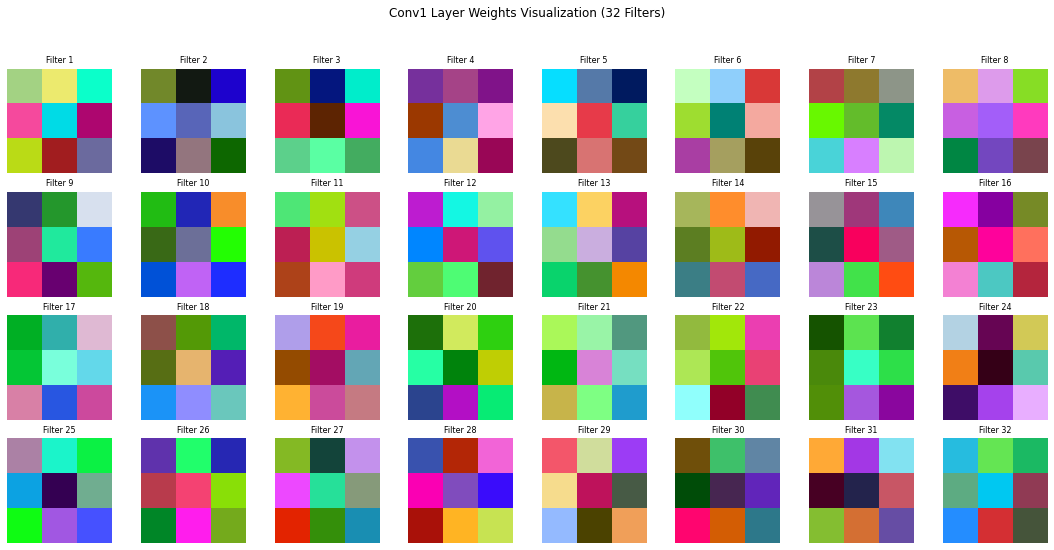

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Conv1 가중치 시각화 함수
def visualize_conv_weights(weights):
    # weights shape: (커널 높이, 커널 너비, 입력 채널, 출력 채널) = (3, 3, 3, 32)
    
    num_filters = weights.shape[3] # 32개 필터
    
    # 시각화를 위해 4x8 격자로 설정
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # i번째 필터의 RGB 가중치를 가져옴 (3, 3, 3)
            # 가중치를 0~1 범위로 정규화하여 이미지처럼 시각화
            filter_weights = weights[:, :, :, i]
            
            # 필터 내의 최솟값/최댓값을 찾아서 0~1로 스케일링
            min_val = np.min(filter_weights)
            max_val = np.max(filter_weights)
            # 0~1로 정규화 (최소값-최대값 정규화)
            normalized_filter = (filter_weights - min_val) / (max_val - min_val)
            
            ax.imshow(normalized_filter) # RGB 필터 시각화
            ax.set_title(f'Filter {i+1}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off') # 남은 축은 숨김
            
    plt.suptitle("Conv1 Layer Weights Visualization (32 Filters)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n--- Conv1 가중치 시각화 (학습된 필터 확인) ---")
# weights_c1: Conv1 레이어의 가중치 변수
visualize_conv_weights(weights_c1)


--- Conv1 편향 분포 분석 ---


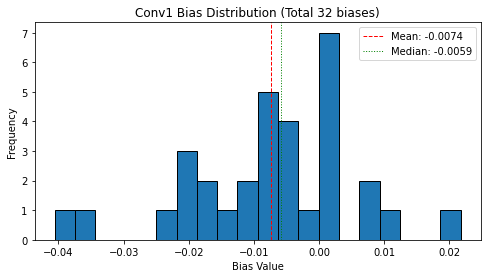


--- Dense1 편향 분포 분석 ---


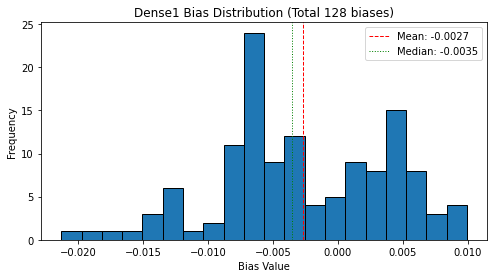

In [17]:
# 편향 값의 분포 분석 (히스토그램)
def visualize_bias_distribution(biases, layer_name):
    plt.figure(figsize=(8, 4))
    plt.hist(biases, bins=20, edgecolor='black')
    
    # 평균과 중앙값을 표시
    mean_bias = np.mean(biases)
    median_bias = np.median(biases)
    plt.axvline(mean_bias, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bias:.4f}')
    plt.axvline(median_bias, color='g', linestyle='dotted', linewidth=1, label=f'Median: {median_bias:.4f}')
    
    plt.title(f'{layer_name} Bias Distribution (Total {len(biases)} biases)')
    plt.xlabel("Bias Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

print("\n--- Conv1 편향 분포 분석 ---")
# biases_c1: Conv1 레이어의 편향 변수
visualize_bias_distribution(biases_c1, "Conv1")

print("\n--- Dense1 편향 분포 분석 ---")
# biases_d1: Dense1 레이어의 편향 변수
visualize_bias_distribution(biases_d1, "Dense1")